In [1]:
import os
import datetime
import IPython
IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

#mpl.rcParams["figure.figsize"] = (8,6)
#mpl.rcParams["axes.grid"] = False

# Data Exploration

- description of variables
- plots and histogram
- analysis/comments on the distribution

In [2]:
# Reset the option for maximum rows displayed in the output (if it was previously modified)
pd.reset_option("display.max_rows")

# Download the CSV file from the provided URL using TensorFlow's utility function and store it locally.
# 'origin' specifies the URL of the CSV file.
# 'fname' is the name under which the file will be saved.
# 'cache_dir' specifies the directory where the file will be cached (in this case, '/content').
# 'cache_subdir' is the subdirectory within the cache where the file will be stored.
csv_path = tf.keras.utils.get_file(
    origin='https://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

# Show the path to the downloaded CSV file
csv_path

# Load the CSV file into a Pandas DataFrame.
df = pd.read_csv(csv_path)

# Display the first 5 rows of the DataFrame to inspect the data.
df.head()


2703553/2703553 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              53 non-null     object 
 1   temp                 40575 non-null  float64
 2   rain_1h              40575 non-null  float64
 3   snow_1h              40575 non-null  float64
 4   clouds_all           40575 non-null  int64  
 5   weather_main         40575 non-null  object 
 6   weather_description  40575 non-null  object 
 7   date_time            40575 non-null  object 
 8   traffic_volume       40575 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.8+ MB


In [4]:
df['date_time'] = pd.to_datetime(df['date_time'])  # Convert the 'date_time' column to datetime format

df['hour'] = df['date_time'].dt.hour  # Extract the hour from the 'date_time' column
df['dayofweek'] = df['date_time'].dt.dayofweek  # Extract the day of the week (0 = Monday, 6 = Sunday)
df['month'] = df['date_time'].dt.month  # Extract the month (1 = January, 12 = December)

df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              53 non-null     object        
 1   temp                 40575 non-null  float64       
 2   rain_1h              40575 non-null  float64       
 3   snow_1h              40575 non-null  float64       
 4   clouds_all           40575 non-null  int64         
 5   weather_main         40575 non-null  object        
 6   weather_description  40575 non-null  object        
 7   date_time            40575 non-null  datetime64[ns]
 8   traffic_volume       40575 non-null  int64         
 9   hour                 40575 non-null  int32         
 10  dayofweek            40575 non-null  int32         
 11  month                40575 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(2), object(3)
memory usage: 3.3+ MB


In [5]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume,hour,dayofweek,month
count,40575.000000,40575.000000,40575.000000,40575.000000,40575,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.316763,0.318632,0.000117,44.199162,2015-12-23 22:16:28.835489792,3290.650474,11.514750,3.006778,6.489045
min,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000,0.000000,0.000000,1.000000
25%,271.840000,0.000000,0.000000,1.000000,2014-02-02 19:30:00,1248.500000,5.000000,1.000000,4.000000
50%,282.860000,0.000000,0.000000,40.000000,2016-06-02 14:00:00,3427.000000,12.000000,3.000000,7.000000
75%,292.280000,0.000000,0.000000,90.000000,2017-08-02 23:30:00,4952.000000,18.000000,5.000000,9.000000
max,310.070000,9831.300000,0.510000,100.000000,2018-09-30 23:00:00,7280.000000,23.000000,6.000000,12.000000
std,13.816618,48.812640,0.005676,38.683447,NaN,1984.772909,6.949889,1.998947,3.373618


- Min temp absolute 0 is impossible
- Median temp 282 (48F) and Max temp 310 (98F)
- Max rainfall in 1h = 9,831 mm = 387 inches, which is impossible
  
Fix outliers for the sake of visulizations

In [6]:
# Fix impossible rainfall amounts by dividing extremely high values by 100
df.loc[df['rain_1h'] > 250, 'rain_1h'] = df['rain_1h'] / 100

# Display rows where the fixed 'rain_1h' values are still greater than 25 (likely outliers for further investigation)
df.loc[df['rain_1h'] > 25]


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,dayofweek,month
5850,NaN,295.82,44.450,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802,11,0,6
6317,NaN,292.65,25.320,0.0,8,Rain,very heavy rain,2013-07-14 06:00:00,958,6,6,7
6854,NaN,289.10,55.630,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315,2,2,8
9127,NaN,264.50,28.700,0.0,64,Rain,very heavy rain,2013-12-19 23:00:00,1190,23,3,12
14333,NaN,292.02,27.570,0.0,90,Rain,very heavy rain,2015-07-13 00:00:00,492,0,0,7
15166,NaN,294.49,25.460,0.0,90,Rain,very heavy rain,2015-08-16 21:00:00,2118,21,6,8
21224,NaN,302.11,98.313,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535,17,0,7
22082,NaN,297.71,31.750,0.0,0,Rain,very heavy rain,2016-08-16 17:00:00,4913,17,1,8


In [7]:
# Fix specific 0 temperature values by interpolating the average of known nearby values for a specific date (Feb 2, 2014)
df.loc[(df['date_time'].dt.to_period('D') == '2014-02-02') & (df['temp'] == 0), 'temp'] = (255.37 + 255.62) / 2

# Fix 0 temperature values on Jan 31, 2014 by setting the value to a known nearby temperature (255.93 K)
df.loc[(df['date_time'].dt.to_period('D') == '2014-01-31') & (df['temp'] == 0), 'temp'] = 255.93


In [8]:
# check for missing traffic volume
df.loc[df['traffic_volume']==0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,dayofweek,month
21507,NaN,296.68,0.0,0.0,40,Rain,light rain,2016-07-23 18:00:00,0,18,5,7
21512,NaN,295.90,0.0,0.0,90,Haze,haze,2016-07-23 23:00:00,0,23,5,7


Only two observations are missing traffic volume, should not impact performance

In [9]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume,hour,dayofweek,month
count,40575.000000,40575.000000,40575.000000,40575.000000,40575,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.379775,0.078755,0.000117,44.199162,2015-12-23 22:16:28.835489792,3290.650474,11.514750,3.006778,6.489045
min,243.390000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000,0.000000,0.000000,1.000000
25%,271.840000,0.000000,0.000000,1.000000,2014-02-02 19:30:00,1248.500000,5.000000,1.000000,4.000000
50%,282.860000,0.000000,0.000000,40.000000,2016-06-02 14:00:00,3427.000000,12.000000,3.000000,7.000000
75%,292.280000,0.000000,0.000000,90.000000,2017-08-02 23:30:00,4952.000000,18.000000,5.000000,9.000000
max,310.070000,98.313000,0.510000,100.000000,2018-09-30 23:00:00,7280.000000,23.000000,6.000000,12.000000
std,13.097795,0.911134,0.005676,38.683447,NaN,1984.772909,6.949889,1.998947,3.373618


Text(0.5, 1.0, 'Median Hourly Traffic Volume by Day')

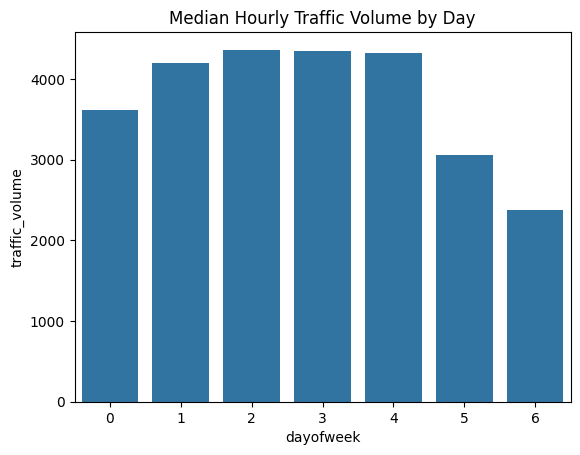

In [10]:
# Create a bar plot for median traffic volume by day of the week
sns.barplot(
    y="traffic_volume",  # Y-axis will show the traffic volume (median values)
    x="dayofweek",       # X-axis will show the day of the week (0 = Monday, 6 = Sunday)
    data=df.groupby('dayofweek')['traffic_volume'].median().to_frame().reset_index()  # Group data by day of week and calculate the median traffic volume for each day
)

# Add a title to the plot
plt.title('Median Hourly Traffic Volume by Day')


Text(0.5, 1.0, 'Median Hourly Traffic Volume by Month of Year')

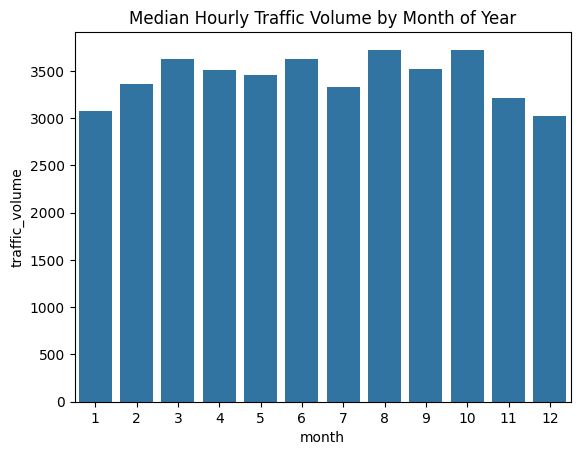

In [11]:
# Create a bar plot for median traffic volume by month of the year
sns.barplot(
    y="traffic_volume",  # Y-axis will show the traffic volume (median values)
    x="month",           # X-axis will show the month of the year (1 = January, 12 = December)
    data=df.groupby('month')['traffic_volume'].median().to_frame().reset_index()  # Group data by month and calculate the median traffic volume for each month
)

# Add a title to the plot
plt.title('Median Hourly Traffic Volume by Month of Year')


Text(0.5, 1.0, 'Median Hourly Traffic Volume by Hour of Day')

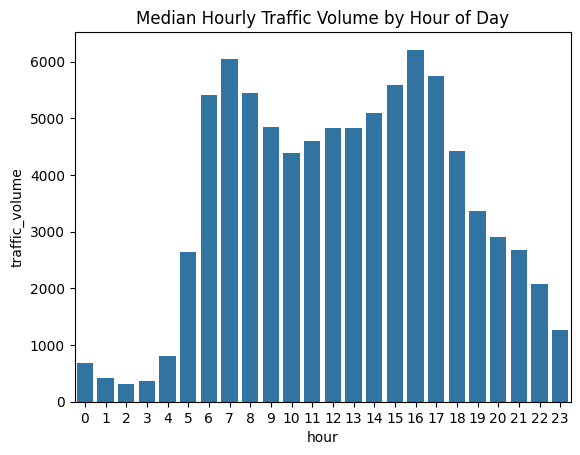

In [12]:
# Create a bar plot for median traffic volume by hour of the day
sns.barplot(
    y="traffic_volume",  # Y-axis will show the traffic volume (median values)
    x="hour",            # X-axis will show the hour of the day (0 = midnight, 23 = 11 PM)
    data=df.groupby('hour')['traffic_volume'].median().to_frame().reset_index()  # Group data by hour and calculate the median traffic volume for each hour of the day
)

# Add a title to the plot
plt.title('Median Hourly Traffic Volume by Hour of Day')


,date_time,traffic_volume
holiday,,
Christmas Day,5,846.600000
Columbus Day,5,519.400000
Independence Day,5,1076.000000
Labor Day,5,1013.200000
Martin Luther King Jr Day,3,592.666667
Memorial Day,5,1107.600000
New Years Day,5,1324.600000
State Fair,5,634.800000
Thanksgiving Day,5,953.600000


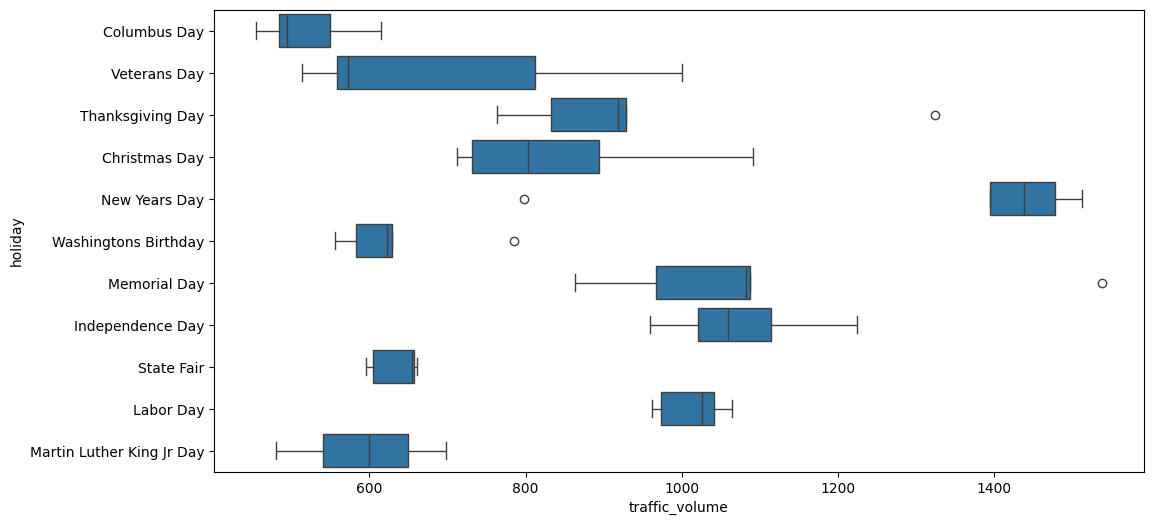

In [13]:
# Create a box plot showing traffic volume by holiday status
plt.figure(figsize=(12, 6))  # Set the figure size
ax = sns.boxplot(y='holiday', x='traffic_volume', data=df, showfliers=True)  # Show outliers in the box plot

# Calculate the number of observations and average traffic volume by holiday
df.groupby('holiday').agg({'date_time':'count', 'traffic_volume':'mean'})


,date_time,traffic_volume
weather_main,,
Clear,13366,3055.254751
Clouds,15123,3616.988230
Drizzle,515,3159.821359
Fog,201,2724.442786
Haze,766,3597.939948
Mist,3069,2854.214076
Rain,4769,3355.270287
Smoke,15,2559.666667
Snow,2297,3001.861123


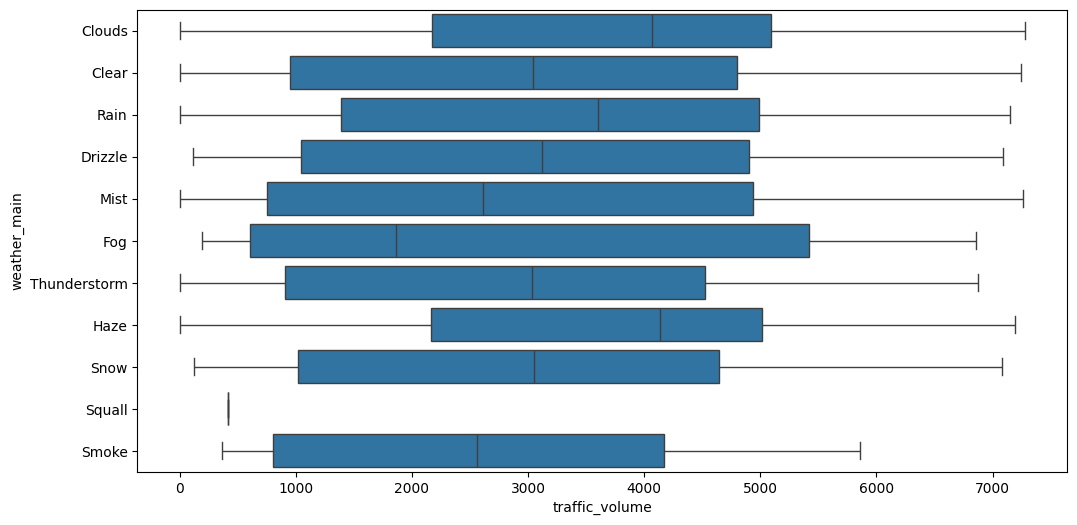

In [14]:
plt.figure(figsize=(12, 6))  # Set the figure size to 12x6 inches
ax = sns.boxplot(y='weather_main', x='traffic_volume', data=df, showfliers=True)  # Create a boxplot of traffic volume by weather type

df.groupby('weather_main').agg({'date_time':'count', 'traffic_volume':'mean'})


In [15]:
# Count and print the number of observations where there is measurable rain (rainfall > 0 in the last hour)
print('observations with measurable rain:  ', df.loc[df['rain_1h'] > 0].shape[0])

# Calculate and print the percentage of observations where there is measurable rain
print('percent of obs with measurable rain:', df.loc[df['rain_1h'] > 0].shape[0] / df.shape[0] * 100)

# Count and print the number of observations where there is measurable snow (snowfall > 0 in the last hour)
print('observations with measurable snow:  ', df.loc[df['snow_1h'] > 0].shape[0])

# Calculate and print the percentage of observations where there is measurable snow
print('percent of obs with measurable snow:', df.loc[df['snow_1h'] > 0].shape[0] / df.shape[0] * 100)


observations with measurable rain:   2054
percent of obs with measurable rain: 5.062230437461491
observations with measurable snow:   31
percent of obs with measurable snow: 0.07640172520024646


In [16]:
# Check how many "Rain" labels exist in weather_main vs measurable rain
print(df[df['weather_main'] == 'Rain'].shape[0])  # Count of "Rain" labels in weather_main
print(df[df['rain_1h'] > 0].shape[0])  # Count of measurable rain in rain_1h

# Similar check for "Snow"
print(df[df['weather_main'] == 'Snow'].shape[0])  # Count of "Snow" labels in weather_main
print(df[df['snow_1h'] > 0].shape[0])  # Count of measurable snow in snow_1h


4769
2054
2297
31


Number of observations with measurable rain and snow does not match the number of observations by categorical labels

<Axes: xlabel='clouds_all', ylabel='traffic_volume'>

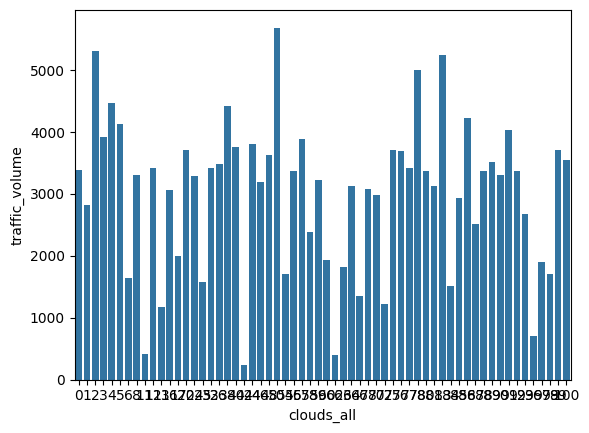

In [17]:
sns.barplot(y="traffic_volume", x="clouds_all", data=df.groupby('clouds_all')['traffic_volume'].mean().to_frame().reset_index())


C:\Users\presh\AppData\Local\Temp\ipykernel_39560\2282222510.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cloud_traffic_binned = df.groupby('cloud_cover_bins')['traffic_volume'].mean().to_frame().reset_index()


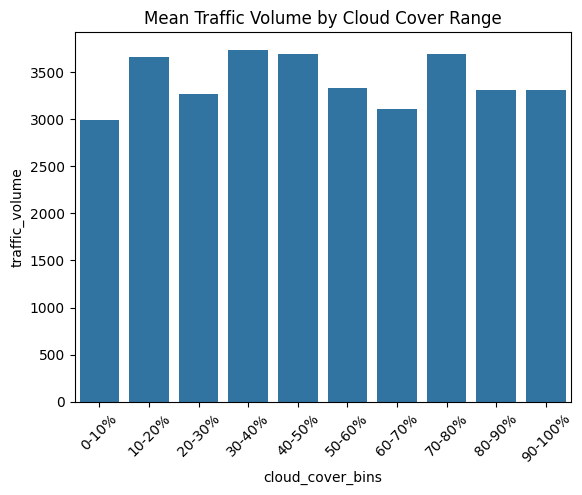

In [19]:
# Create bins for cloud cover (e.g., 0-10%, 10-20%, etc.)
df['cloud_cover_bins'] = pd.cut(df['clouds_all'], bins=10, labels=["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"])

# Group by the new binned cloud cover values
cloud_traffic_binned = df.groupby('cloud_cover_bins')['traffic_volume'].mean().to_frame().reset_index()

# Create a barplot with binned cloud cover values
sns.barplot(y="traffic_volume", x="cloud_cover_bins", data=cloud_traffic_binned)
plt.title('Mean Traffic Volume by Cloud Cover Range')
plt.xticks(rotation=45)
plt.show()



Based on the visualizations, cloud cover alone does not seem to have a significant or clear impact on traffic volume.

<Axes: xlabel='temp', ylabel='traffic_volume'>

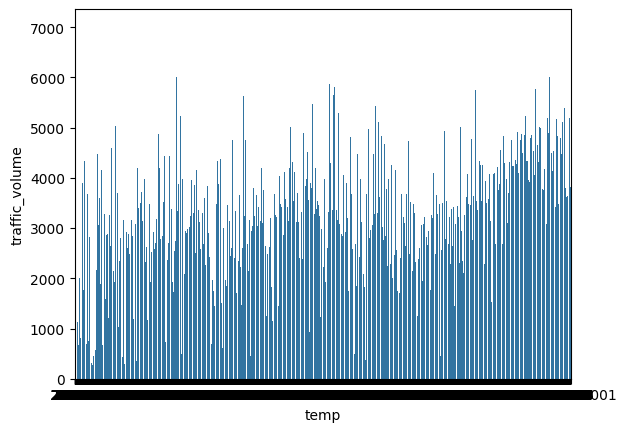

In [21]:
# does temp have an impact on traffic volume? 
sns.barplot(y="traffic_volume", x="temp", data=df.groupby('temp')['traffic_volume'].mean().to_frame().reset_index())
 


C:\Users\presh\AppData\Local\Temp\ipykernel_39560\2638993662.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_binned_traffic_data = df.groupby('temp_bins')['traffic_volume'].mean().to_frame().reset_index()


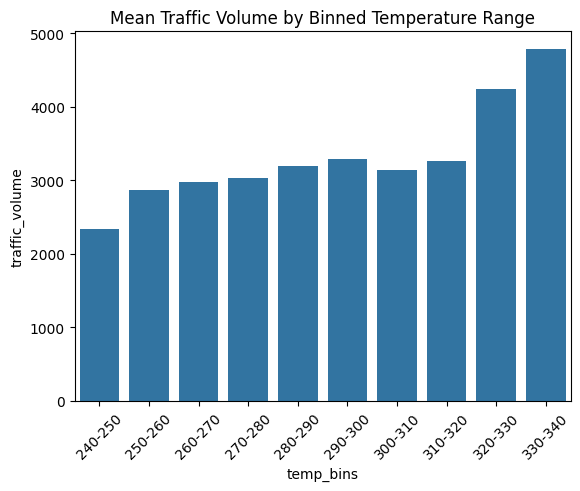

In [22]:
# Bin the temperature into ranges (e.g., 240-250, 250-260, etc.)
df['temp_bins'] = pd.cut(df['temp'], bins=10, labels=["240-250", "250-260", "260-270", "270-280", "280-290", "290-300", "300-310", "310-320", "320-330", "330-340"])

# Group the data by the binned temperature and calculate the mean traffic volume for each bin
temp_binned_traffic_data = df.groupby('temp_bins')['traffic_volume'].mean().to_frame().reset_index()

# Create a barplot to visualize the relationship between binned temperature and traffic volume
# 'x' represents binned temperature ('temp_bins') and 'y' represents the mean traffic volume ('traffic_volume')
sns.barplot(y="traffic_volume", x="temp_bins", data=temp_binned_traffic_data)

# Add title and rotate x-axis labels for readability
plt.title('Mean Traffic Volume by Binned Temperature Range')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()


summer months with warmer temperatures lead to higher traffic volumes, while colder months (winter) result in lower traffic due to weather-related factors and reduced travel demand.

In [23]:
# Group the data by the 'weather_description' column (detailed weather conditions)
# Aggregate two pieces of information for each weather description:
# 1. 'date_time': Count the number of observations for each weather description
# 2. 'traffic_volume': Calculate the mean traffic volume for each weather description
weather_data = df.groupby('weather_description').agg({
    'date_time': 'count',    # Count the number of times each weather condition appears in the dataset
    'traffic_volume': 'mean' # Calculate the average traffic volume for each weather condition
})

# Sort the result by 'date_time' (i.e., the count of observations) in descending order
# This allows us to see which weather descriptions have the most data points first
weather_data_sorted = weather_data.sort_values('date_time', ascending=False)

# Display the sorted DataFrame
weather_data_sorted


,date_time,traffic_volume
weather_description,,
sky is clear,11642,3000.910067
overcast clouds,5072,3375.779771
broken clouds,4650,3658.193978
scattered clouds,3451,3876.298464
mist,3069,2854.214076
light rain,2831,3389.292476
few clouds,1950,3687.205128
Sky is Clear,1724,3422.238979
light snow,1588,3060.358942


### Key Takeways:

- **Clear and cloudy weather conditions** tend to support **higher traffic volumes**, while hazardous conditions like **mist**, **fog**, and **heavy snow** tend to **reduce traffic**.
- **Rare weather conditions** (e.g., **squalls** or **freezing rain**) may drastically reduce traffic volume, but these are represented by very **few observations** and should be interpreted with caution.
- There are some **data inconsistencies** (e.g., different labels for "clear sky") that could be **cleaned** for more accurate analysis.

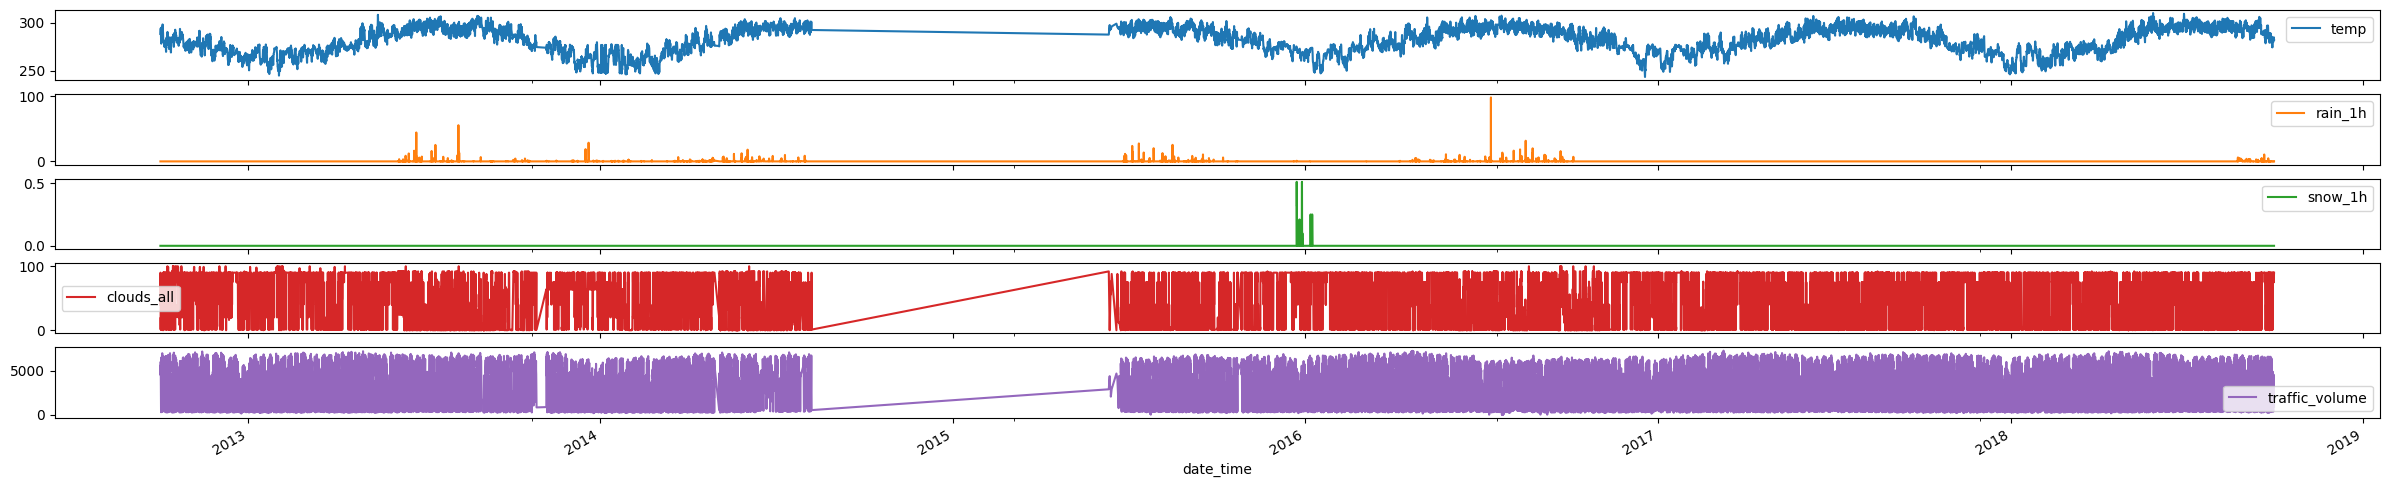

In [24]:
## From the TensorFlow Tutorial

# Step 1: Define the columns (features) you want to visualize
# These columns include temperature, rainfall in the last hour, snowfall in the last hour, cloud cover, and traffic volume
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

# Step 2: Create a new DataFrame that only contains the selected columns
# This makes it easier to focus on these specific features for visualization
plot_features = df[plot_cols]

# Step 3: Set the index of the new DataFrame to 'date_time' so that we can visualize the data over time
# This ensures the x-axis of the plot will use the timestamps for each observation
plot_features.index = df['date_time']

# Step 4: Plot the features over time, each on a separate subplot
# 'subplots=True' means each feature will get its own subplot
# 'figsize=(30,6)' sets the size of the plot to be 30 inches wide and 6 inches tall to provide ample space for viewing
_ = plot_features.plot(subplots=True, figsize=(30,6))

# The underscore (_) is used to suppress any unwanted output


Missing data from August 2014 - July 2015

### Comments on Exploratory Data Analysis

- **Missing data from August 2014 - July 2015**: 
  There is a noticeable gap in the dataset during this period.
  
- **Extreme high or low values for temperature and rainfall**:
  A few extreme or impossible values for temperature and rain were identified and fixed during data cleaning.

- **More observations labeled as "rain" or "snow" than measurable amounts**:
  There are significantly more observations labeled as "rain" or "snow" than there are observations with measurable rainfall or snowfall (> 0 mm). This suggests that the labels describe general conditions, but actual precipitation is not always recorded.

- **Most noticeable patterns for traffic volume seem to be based on (roughly in order)**:
  1. **Time of Day**: Traffic peaks during morning and evening rush hours on weekdays.
  2. **Day of Week**: Weekdays have higher traffic, while weekends typically see lower traffic.
  3. **Holiday or None**: Holidays often result in lower traffic volumes.
  4. **Month of Year**: There are seasonal variations in traffic, but they tend to be less pronounced than time-based factors.
  5. **Temperature**: Extreme temperatures can affect traffic, but the impact is moderate.
  6. **Weather Category**: Weather, like rain or snow, has a small effect on traffic but is generally less influential than daily commuting patterns.

- **Traffic volume is more impacted by commute patterns (to work/school on weekdays with no holidays)**:
  Weather has a smaller effect compared to commuting schedules, which primarily drive traffic volume patterns.


# Data Cleaning and Further Exploration

In [42]:
# Create binary column for Holidays, considering NaN values as non-holidays
df['d_holiday'] = np.where(df['holiday'].isna(), 0, 1)

# Display the first few rows of the DataFrame to verify the new column
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              53 non-null     object        
 1   temp                 40575 non-null  float64       
 2   rain_1h              40575 non-null  float64       
 3   snow_1h              40575 non-null  float64       
 4   clouds_all           40575 non-null  int64         
 5   weather_main         40575 non-null  object        
 6   weather_description  40575 non-null  object        
 7   date_time            40575 non-null  datetime64[ns]
 8   traffic_volume       40575 non-null  int64         
 9   hour                 40575 non-null  int32         
 10  dayofweek            40575 non-null  int32         
 11  month                40575 non-null  int32         
 12  cloud_cover_bins     40575 non-null  category      
 13  temp_bins            40575 non-

In [29]:
# Create binary column for workday
# A workday is defined as a day that is not a holiday ('holiday' is 'Nan') and is a weekday (dayofweek < 5)
df['workday'] = np.where(df['holiday'].isna() & (df['dayofweek'] < 5), 1, 0)

# Display the last few rows of the DataFrame to verify the new 'workday' column
df.tail()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,dayofweek,month,cloud_cover_bins,temp_bins,d_holiday,workday
40570,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543,19,6,9,70-80%,300-310,0,0
40571,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781,20,6,9,80-90%,290-300,0,0
40572,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159,21,6,9,80-90%,290-300,0,0
40573,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450,22,6,9,80-90%,290-300,0,0
40574,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954,23,6,9,80-90%,290-300,0,0


In [49]:
# Create binary column for morning rush hour
# A morning rush hour is defined as a workday (workday == 1) and the hour between 6 AM (hour > 5) and 10 AM (hour < 10)
df['morning_rush'] = np.where((df['workday'] == 1) & (df['hour'] > 5) & (df['hour'] < 10), 1, 0)

# Create binary column for evening rush hour
# An evening rush hour is defined as a workday (workday == 1) and the hour between 2 PM (hour > 13) and 6 PM (hour < 18)
df['evening_rush'] = np.where((df['workday'] == 1) & (df['hour'] > 13) & (df['hour'] < 18), 1, 0)

# Display the first few rows of the DataFrame to verify the new columns
df.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,...,Year_sin,Year_cos,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
0,NaN,288.28,0.0,0.0,40,Clouds,none,2012-10-02 09:00:00,5545,9,...,-0.999766,0.021642,0,0,0,0,0,0,0,0
1,NaN,289.36,0.0,0.0,75,Clouds,none,2012-10-02 10:00:00,4516,10,...,-0.999750,0.022358,0,0,0,0,0,0,0,0
2,NaN,289.58,0.0,0.0,90,Clouds,none,2012-10-02 11:00:00,4767,11,...,-0.999734,0.023075,0,0,0,0,0,0,0,0
3,NaN,290.13,0.0,0.0,90,Clouds,none,2012-10-02 12:00:00,5026,12,...,-0.999717,0.023791,0,0,0,0,0,0,0,0
4,NaN,291.14,0.0,0.0,75,Clouds,none,2012-10-02 13:00:00,4918,13,...,-0.999700,0.024508,0,0,0,0,0,0,0,0


In [31]:
# Define a dictionary to map specific weather descriptions to broader categories
weather_map = {
    'freezing rain': 'snow',
    'sleet': 'snow',
    'proximity thunderstorm with drizzle': 'light rain',
    'drizzle': 'light rain',
    'thunderstorm with light drizzle': 'light rain',
    'light rain and snow': 'light snow',
    'thunderstorm with rain': 'rain',
    'proximity thunderstorm with rain': 'rain',
    'light shower snow': 'light snow',
    'light intensity shower rain': 'light rain',
    'thunderstorm with heavy rain': 'heavy rain',
    'smoke': 'fog',
    'heavy intensity drizzle': 'rain',
    'thunderstorm with light rain': 'light rain',
    'thunderstorm': 'rain',
    'proximity shower rain': 'light rain',
    'SQUALLS': 'heavy rain',
    'proximity thunderstorm': 'light rain',
    'light intensity drizzle': 'light rain',
    'heavy intensity rain': 'heavy rain',
    'very heavy rain': 'heavy rain',
    'Sky is Clear': 'none',
    'sky is clear': 'none',
    'few clouds': 'none',
    'scattered clouds': 'none',
    'broken clouds': 'none',
    'overcast clouds': 'none',
    'mist': 'light rain',
    'moderate rain': 'rain'
}

# Use the replace method to map the values in the weather_description column
df['weather_description'] = df['weather_description'].replace(weather_map)

# Verify the changes by checking the counts for each unique weather description
df.groupby('weather_description').size()


weather_description
fog             216
haze            766
heavy rain      441
heavy snow      500
light rain     6896
light snow     1602
none          28489
rain           1469
snow            196
dtype: int64

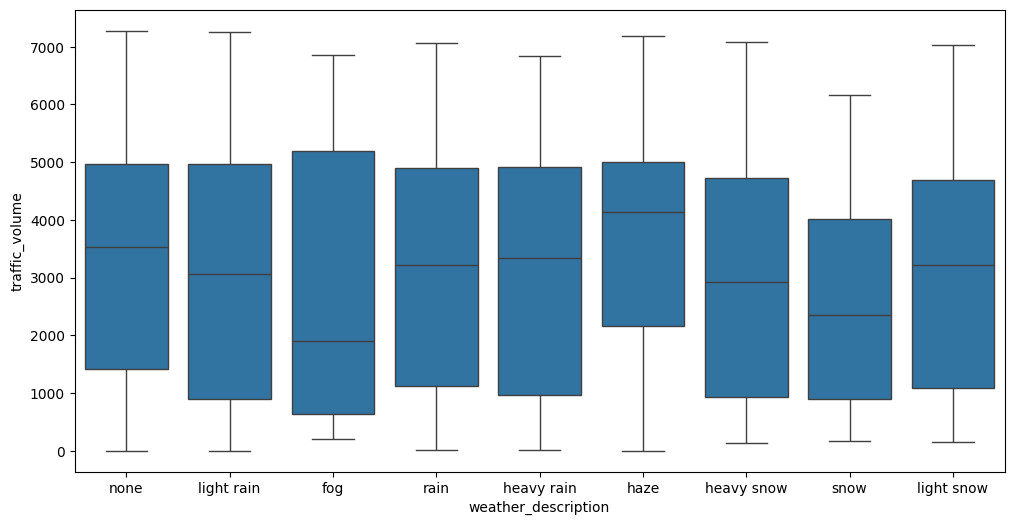

In [32]:
# Create a boxplot to visualize traffic volume by weather description

# Set the size of the plot to 12 inches wide and 6 inches tall
plt.figure(figsize=(12, 6))

# Create a boxplot with 'weather_description' on the x-axis and 'traffic_volume' on the y-axis
# 'showfliers=True' means outliers will be shown in the plot
ax = sns.boxplot(x='weather_description', y='traffic_volume', data=df, showfliers=True)

# Display the plot
plt.show()


- The most noticeable impact on reducing traffic is **snow**, **heavy snow**, and **fog**.
- **Rain** has a moderate impact, but it does not drastically reduce traffic volumes.
- **Clear weather** (none) and **haze** have the least impact on traffic, with more consistent traffic flows during these conditions.

In [51]:
# Create binary (dummy) variables for the weather descriptions
d_weather = pd.get_dummies(df['weather_description'])

# Convert boolean columns (True/False) to integers (1/0)
d_weather = d_weather.astype(int)

# Concatenate the dummy columns directly into the original DataFrame
df = pd.concat([df, d_weather], axis=1)

# Drop the 'none' column, as it serves as the baseline category
df.drop(columns=['none'], inplace=True)

# Verify the changes by displaying the rows where the weather is not 'none'
df.loc[df['weather_description'] != 'None'].head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,...,rain,snow,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
0,NaN,288.28,0.0,0.0,40,Clouds,none,2012-10-02 09:00:00,5545,9,...,0,0,0,0,0,0,0,0,0,0
1,NaN,289.36,0.0,0.0,75,Clouds,none,2012-10-02 10:00:00,4516,10,...,0,0,0,0,0,0,0,0,0,0
2,NaN,289.58,0.0,0.0,90,Clouds,none,2012-10-02 11:00:00,4767,11,...,0,0,0,0,0,0,0,0,0,0
3,NaN,290.13,0.0,0.0,90,Clouds,none,2012-10-02 12:00:00,5026,12,...,0,0,0,0,0,0,0,0,0,0
4,NaN,291.14,0.0,0.0,75,Clouds,none,2012-10-02 13:00:00,4918,13,...,0,0,0,0,0,0,0,0,0,0


# Data Transformation

In [53]:
# Constants to represent the number of seconds in a day and a year
day = 24 * 60 * 60        # Seconds in a day
year = (365.2425) * day    # Seconds in a year (accounting for leap years)

# Convert 'date_time' column to timestamps (seconds since the Unix epoch)
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

# Cyclical encoding for the time of day
# Sine and cosine transforms to represent time within a 24-hour cycle
df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))  # Sine for time of day
df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))  # Cosine for time of day

# Cyclical encoding for the time of year
# Sine and cosine transforms to represent time within a 365-day cycle (a year)
df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))  # Sine for time of year
df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))  # Cosine for time of year

# Display the first few rows of the DataFrame to verify the new columns
df.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,...,rain,snow,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
0,NaN,288.28,0.0,0.0,40,Clouds,none,2012-10-02 09:00:00,5545,9,...,0,0,0,0,0,0,0,0,0,0
1,NaN,289.36,0.0,0.0,75,Clouds,none,2012-10-02 10:00:00,4516,10,...,0,0,0,0,0,0,0,0,0,0
2,NaN,289.58,0.0,0.0,90,Clouds,none,2012-10-02 11:00:00,4767,11,...,0,0,0,0,0,0,0,0,0,0
3,NaN,290.13,0.0,0.0,90,Clouds,none,2012-10-02 12:00:00,5026,12,...,0,0,0,0,0,0,0,0,0,0
4,NaN,291.14,0.0,0.0,75,Clouds,none,2012-10-02 13:00:00,4918,13,...,0,0,0,0,0,0,0,0,0,0


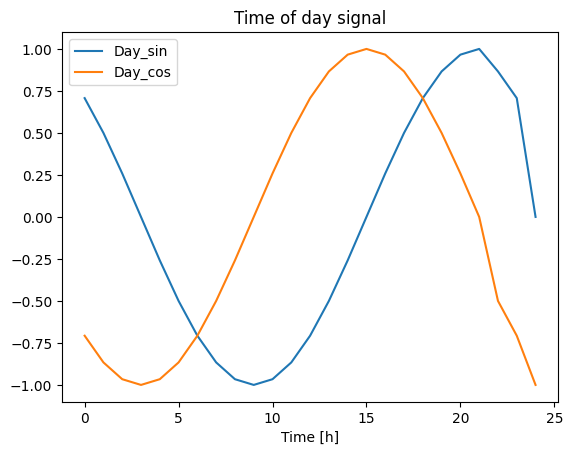

In [54]:
## From the TensorFlow Tutorial

# Plot the sine values for the time of day
plt.plot(np.array(df['Day_sin'])[:25], label='Day_sin')

# Plot the cosine values for the time of day
plt.plot(np.array(df['Day_cos'])[:25], label='Day_cos')

# Set the x-axis label
plt.xlabel('Time [h]')

# Add a title to the plot
plt.title('Time of day signal')

# Display the legend to differentiate between the sine and cosine lines
plt.legend()

# Show the plot
plt.show()


In [40]:
# Create a new DataFrame containing only the numeric columns and encoded categorical columns
df_num2 = df[['traffic_volume', 'temp', 'hour', 'dayofweek', 'month', 'd_holiday', 'workday', 
              'morning_rush', 'evening_rush', 'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos',
              'fog', 'haze', 'heavy rain', 'heavy snow', 'light rain', 'light snow', 'rain', 'snow']].copy()

# Display the last few rows of the new numeric DataFrame
df_num2.tail()


,traffic_volume,temp,hour,dayofweek,month,d_holiday,workday,morning_rush,evening_rush,Day_sin,...,Year_sin,Year_cos,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
40570,3543,283.45,19,6,9,0,0,0,0,-0.965926,...,-0.999910,-0.013421,0,0,0,0,0,0,0,0
40571,2781,282.76,20,6,9,0,0,0,0,-0.866025,...,-0.999919,-0.012705,0,0,0,0,0,0,0,0
40572,2159,282.73,21,6,9,0,0,0,0,-0.707107,...,-0.999928,-0.011988,0,0,0,0,1,0,0,0
40573,1450,282.09,22,6,9,0,0,0,0,-0.500000,...,-0.999936,-0.011271,0,0,0,0,0,0,0,0
40574,954,282.12,23,6,9,0,0,0,0,-0.258819,...,-0.999944,-0.010554,0,0,0,0,0,0,0,0


# Train / Test Split
- use dataset with numeric values + encoded categorical values

In [56]:
# Separate the last 5000 rows for the test set
test_df = df_num2[-5000:]

# The remaining rows will be used for training and validation
train_val_df = df_num2[:-5000]

# Print the shape of the training/validation set (rows, columns)
print(train_val_df.shape)

# Display the last few rows of the training/validation set
train_val_df.tail()


(35575, 21)


,traffic_volume,temp,hour,dayofweek,month,d_holiday,workday,morning_rush,evening_rush,Day_sin,...,Year_sin,Year_cos,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
35570,1389,271.93,18,0,3,0,1,0,0,-1.000000,...,0.892506,0.451036,0,0,0,1,0,0,0,0
35571,1117,271.65,19,0,3,0,1,0,0,-0.965926,...,0.892829,0.450397,0,0,0,1,0,0,0,0
35572,844,271.28,20,0,3,0,1,0,0,-0.866025,...,0.893151,0.449757,0,0,0,0,0,0,0,1
35573,753,271.15,21,0,3,0,1,0,0,-0.707107,...,0.893473,0.449116,0,0,0,0,0,0,0,1
35574,694,271.15,22,0,3,0,1,0,0,-0.500000,...,0.893795,0.448476,0,0,0,0,0,0,0,1


- The last 5000 rows are held back as the test set, which will be used for evaluating the performance of our machine learning model after training. This ensures that the model is tested on data it has not seen before.
- The rest of the data is used for training and validation.

In [57]:
print(test_df.shape)
test_df.head()

(5000, 21)


,traffic_volume,temp,hour,dayofweek,month,d_holiday,workday,morning_rush,evening_rush,Day_sin,...,Year_sin,Year_cos,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
35575,599,271.36,23,0,3,0,1,0,0,-2.588190e-01,...,0.894116,0.447835,0,0,0,0,0,1,0,0
35576,308,271.43,0,1,3,0,1,0,0,-3.769765e-12,...,0.894437,0.447194,0,0,0,0,0,1,0,0
35577,242,271.43,1,1,3,0,1,0,0,2.588190e-01,...,0.894757,0.446553,0,0,0,0,0,1,0,0
35578,231,271.36,2,1,3,0,1,0,0,5.000000e-01,...,0.895077,0.445911,0,0,0,0,0,1,0,0
35579,335,271.28,3,1,3,0,1,0,0,7.071068e-01,...,0.895397,0.445270,0,0,0,0,0,1,0,0


In [59]:
# Get the total number of rows in the training/validation set
n = len(train_val_df)

# Split the first 70% of the training/validation set into the training set
train_df = train_val_df[0:int(n * 0.7)]

# Split the remaining 30% (after 70%) into the validation set
val_df = train_val_df[int(n * 0.7):-1]

# Print the shape of the training set to verify its size (rows, columns)
print(train_df.shape)

# Display the last few rows of the training set
train_df.tail()

# Print the shape of the validation set to verify its size (rows, columns)
print(val_df.shape)

# Display the first few rows of the validation set
val_df.head()


(24902, 21)
(10672, 21)


,traffic_volume,temp,hour,dayofweek,month,d_holiday,workday,morning_rush,evening_rush,Day_sin,...,Year_sin,Year_cos,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
24902,1205,260.42,23,1,12,0,1,0,0,-2.588190e-01,...,-0.295522,0.955336,0,0,0,0,0,0,0,0
24903,587,260.75,0,2,12,0,1,0,0,-4.363718e-12,...,-0.294837,0.955547,0,0,0,0,0,0,0,0
24904,381,260.59,1,2,12,0,1,0,0,2.588190e-01,...,-0.294152,0.955759,0,0,0,0,0,0,0,0
24905,369,260.42,2,2,12,0,1,0,0,5.000000e-01,...,-0.293467,0.955969,0,0,0,0,0,0,0,0
24906,486,260.34,3,2,12,0,1,0,0,7.071068e-01,...,-0.292782,0.956179,0,0,0,0,0,0,0,0


- Training Set: The first 70% of the data (train_df) will be used to train the machine learning model.
- Validation Set: The remaining 30% (val_df) will be used to validate the model during training and help with hyperparameter tuning.

### Normalize the data

In [60]:
## From the TensorFlow Tutorial

# Calculate the mean and standard deviation of the training data
train_mean = train_df.mean()
train_std = train_df.std()

# Normalize the training data by subtracting the mean and dividing by the standard deviation
train_df = (train_df - train_mean) / train_std

# Normalize the validation data using the same mean and standard deviation from the training set
val_df = (val_df - train_mean) / train_std

# Normalize the test data using the same mean and standard deviation from the training set
test_df = (test_df - train_mean) / train_std

# Display the first few rows of the normalized training data
train_df.head()


,traffic_volume,temp,hour,dayofweek,month,d_holiday,workday,morning_rush,evening_rush,Day_sin,...,Year_sin,Year_cos,fog,haze,heavy rain,heavy snow,light rain,light snow,rain,snow
0,1.149755,0.541804,-0.360910,-1.003127,0.954818,-0.036975,0.633883,2.750085,-0.366013,1.004831,...,-1.379525,0.069429,-0.071596,-0.136422,-0.108547,-0.138243,-0.441351,-0.172425,-0.187642,-0.054593
1,0.632510,0.624278,-0.217380,-1.003127,0.954818,-0.036975,0.633883,-0.363610,-0.366013,0.711228,...,-1.379502,0.070430,-0.071596,-0.136422,-0.108547,-0.138243,-0.441351,-0.172425,-0.187642,-0.054593
2,0.758680,0.641078,-0.073851,-1.003127,0.954818,-0.036975,0.633883,-0.363610,-0.366013,0.369320,...,-1.379479,0.071431,-0.071596,-0.136422,-0.108547,-0.138243,-0.441351,-0.172425,-0.187642,-0.054593
3,0.888871,0.683078,0.069678,-1.003127,0.954818,-0.036975,0.633883,-0.363610,-0.366013,0.002407,...,-1.379455,0.072432,-0.071596,-0.136422,-0.108547,-0.138243,-0.441351,-0.172425,-0.187642,-0.054593
4,0.834582,0.760206,0.213207,-1.003127,0.954818,-0.036975,0.633883,-0.363610,-0.366013,-0.364506,...,-1.379430,0.073433,-0.071596,-0.136422,-0.108547,-0.138243,-0.441351,-0.172425,-0.187642,-0.054593


C:\Users\presh\AppData\Local\Temp\ipykernel_39560\1931017840.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_num2.keys(), rotation=90)


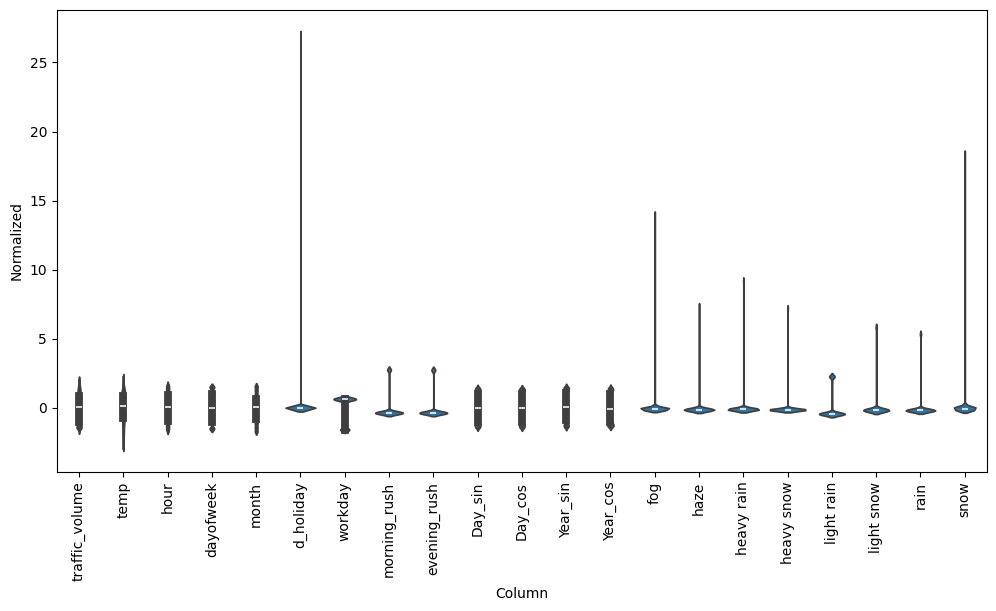

In [61]:
## From the TensorFlow Tutorial

# Standardize the entire dataset using the training set's mean and standard deviation
df_std = (df_num2 - train_mean) / train_std

# Melt the DataFrame to reshape it for easy plotting with Seaborn
df_std = df_std.melt(var_name='Column', value_name='Normalized')

# Create a figure and set its size
plt.figure(figsize=(12, 6))

# Create a violin plot to show the distribution of each feature's normalized values
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

# Rotate x-axis labels to make them readable
_ = ax.set_xticklabels(df_num2.keys(), rotation=90)


C:\Users\presh\AppData\Local\Temp\ipykernel_39560\596491087.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_num2.keys(), rotation=90)


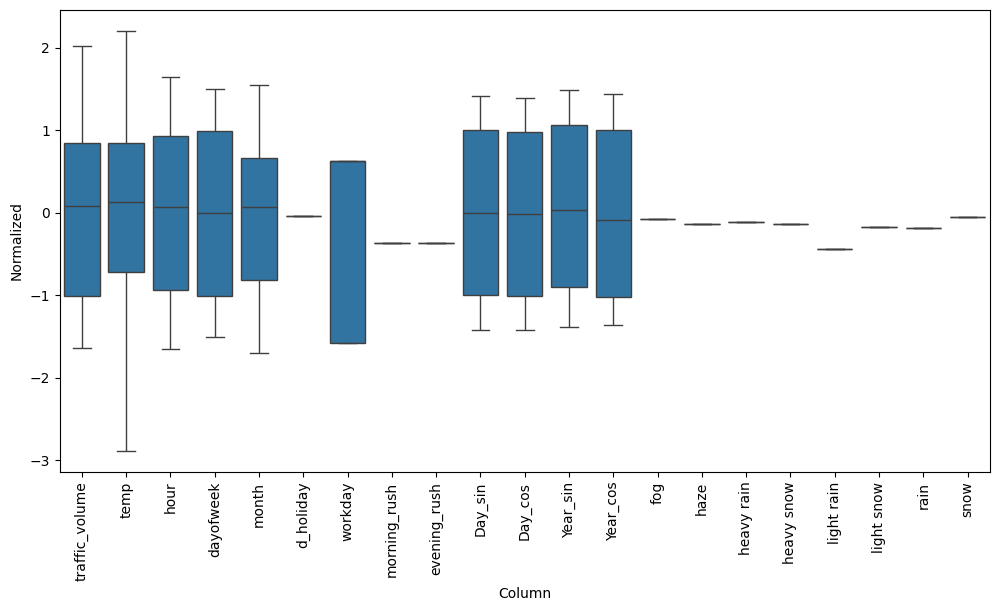

In [62]:
# Plot without outliers

# Create a figure with a size of 12 by 6 inches
plt.figure(figsize=(12, 6))

# Create a boxplot showing the distribution of normalized values without outliers
# 'showfliers=False' will remove the display of outliers in the boxplot
ax = sns.boxplot(x='Column', y='Normalized', data=df_std, showfliers=False)

# Rotate the x-axis labels (feature names) by 90 degrees for better readability
_ = ax.set_xticklabels(df_num2.keys(), rotation=90)

# Show the plot
plt.show()


### Conclusion:

- Most features, such as **`traffic_volume`**, **`temp`**, **`hour`**, **`dayofweek`**, and **`month`**, are symmetrically distributed around 0, indicating good normalization with a standard spread (between -1 and 1).
- **Binary features** (e.g., **`d_holiday`**, **`workday`**, **`morning_rush`**, **`evening_rush`**) have narrow distributions, as expected, since they represent 0/1 values. After normalization, they exhibit little variability.
- The **cyclical time features** (**`Day_sin`**, **`Day_cos`**, **`Year_sin`**, **`Year_cos`**) are uniformly distributed, which is appropriate for encoding time in a cyclical manner.
- **Weather features** like **`fog`**, **`haze`**, and **`rain`** have narrower distributions, suggesting these weather conditions occur infrequently. Features such as **`heavy rain`**, **`heavy snow`**, and **`light snow`** are rare events, which explains their minimal variability.
  
The dataset is well-prepared and ready for further modeling, with most features normalized and without outliers that could skew the training process.


# Window Generator and other Functions/Classes